# A. Basic

**1. Basic Libraries** 

In [2]:
!pip install "protobuf<4.21.0" imbalanced-learn
import warnings
warnings.filterwarnings('ignore')

In [20]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import joblib   
import gc
import os
from collections import Counter 
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import (
    classification_report, accuracy_score, confusion_matrix, 
    precision_score, recall_score, f1_score
)
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.ensemble import RandomForestClassifier 
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler 
import cuml
from cuml.neighbors import KNeighborsClassifier as cuKNeighbors 
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Input, Dense, Dropout, Flatten, BatchNormalization,
    Conv1D, MaxPooling1D, LSTM, Bidirectional, LeakyReLU
)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
print("Libraries Imported Successfully.")

Libraries Imported Successfully.


**2. Load Datasets**

In [5]:
train_path = '/kaggle/input/nids-test-and-train-datasets/train_nids.csv'
test_path = '/kaggle/input/nids-test-and-train-datasets/test_nids.csv'
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

**3. Preparing Data**

In [6]:
X_train = train_df.drop(columns=['Label'])
y_train = train_df['Label']
X_test = test_df.drop(columns=['Label'])
y_test = test_df['Label']
print(f"Original Train Shape: {X_train.shape}") 
target_samples = 150000 
strategy_under = {k: target_samples for k, v in Counter(y_train).items() if v > target_samples}
rus = RandomUnderSampler(sampling_strategy=strategy_under, random_state=42)
X_train, y_train = rus.fit_resample(X_train, y_train)
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)
print(f"Final Balanced Train Shape: {X_train.shape}")
print(f"Final Class Distribution: {Counter(y_train)}")  
model_results = {}

Original Train Shape: (2016638, 20)
Final Balanced Train Shape: (1200000, 20)
Final Class Distribution: Counter({0: 150000, 1: 150000, 2: 150000, 3: 150000, 4: 150000, 5: 150000, 6: 150000, 7: 150000})


**4. Helper Function**

In [7]:
def print_performance(model_name, y_true, y_pred, train_acc=None, cv_scores=None):
    print(f"  PERFORMANCE REPORT: {model_name}")
    if cv_scores is not None:
        print(f"\n[1] 5-Fold Cross Validation Scores:")
        print(f"   Scores:  {cv_scores}")
        print(f"   Average: {np.mean(cv_scores):.4f}")
    else:
        print("\n[1] Cross Validation info not available.")
    test_acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    print(f"\n[2] Performance Metrics:")
    if train_acc:
        print(f"   Training Accuracy:  {train_acc:.4f}")
    print(f"   Testing Accuracy:   {test_acc:.4f}")
    print(f"   Precision:          {prec:.4f}")
    print(f"   Recall:             {rec:.4f}")
    print(f"   F1-Score:           {f1:.4f}")
    model_results[model_name] = {'Accuracy': test_acc, 'F1-Score': f1}
    print(f"\n[3] Confusion Matrix:")
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")
    plt.show()

# B. ML Models

# i. Model 1 - Decision Tree

  PERFORMANCE REPORT: Decision Tree

[1] 5-Fold Cross Validation Scores:
   Scores:  [0.9787125  0.97824167 0.9788625  0.97914583 0.9788625 ]
   Average: 0.9788

[2] Performance Metrics:
   Training Accuracy:  0.9788
   Testing Accuracy:   0.9132
   Precision:          0.9661
   Recall:             0.9132
   F1-Score:           0.9345

[3] Confusion Matrix:


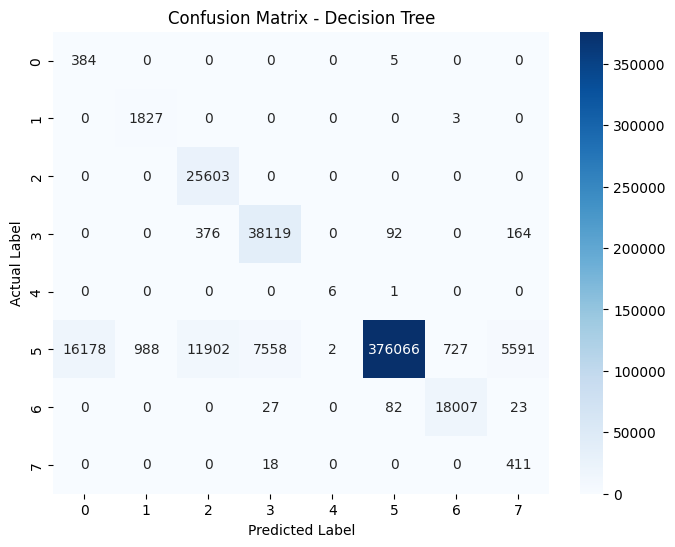

In [8]:
dt_model = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=42) 
cv_scores_dt = cross_val_score(dt_model, X_train, y_train, cv=5, n_jobs=-1) 
dt_model.fit(X_train, y_train) 
y_pred_dt = dt_model.predict(X_test)
train_acc_dt = dt_model.score(X_train, y_train) 
print_performance("Decision Tree", y_test, y_pred_dt, train_acc_dt, cv_scores_dt) 

# ii. Model 2 - KNN

  PERFORMANCE REPORT: K-Nearest Neighbors

[1] 5-Fold Cross Validation Scores:
   Scores:  [0.86217083 0.86162083 0.86149583 0.86182917 0.86179583]
   Average: 0.8618

[2] Performance Metrics:
   Training Accuracy:  0.8585
   Testing Accuracy:   0.8555
   Precision:          0.9262
   Recall:             0.8555
   F1-Score:           0.8747

[3] Confusion Matrix:


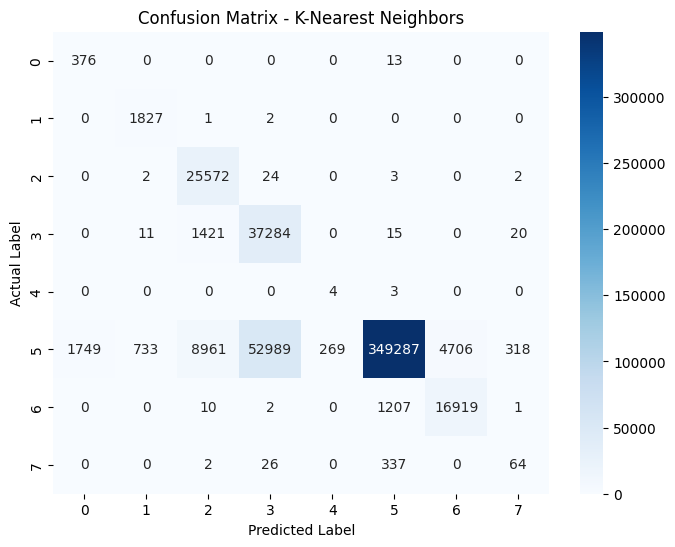

In [9]:
X_train_cuml = X_train.values.astype('float32')
y_train_cuml = y_train.values.astype('float32')
X_test_cuml = X_test.values.astype('float32') 
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_knn = []
for train_idx, val_idx in skf.split(X_train_cuml, y_train_cuml):
    knn_temp = cuKNeighbors(n_neighbors=5)
    knn_temp.fit(X_train_cuml[train_idx], y_train_cuml[train_idx])
    cv_scores_knn.append(knn_temp.score(X_train_cuml[val_idx], y_train_cuml[val_idx])) 
knn_model = cuKNeighbors(n_neighbors=5)
knn_model.fit(X_train_cuml, y_train_cuml)
y_pred_knn = knn_model.predict(X_test_cuml)
if hasattr(y_pred_knn, 'to_numpy'): y_pred_knn = y_pred_knn.to_numpy()
elif hasattr(y_pred_knn, 'get'): y_pred_knn = y_pred_knn.get()
train_acc_knn = knn_model.score(X_train_cuml, y_train_cuml) 
print_performance("K-Nearest Neighbors", y_test, y_pred_knn, train_acc_knn, np.array(cv_scores_knn))

# C. DL Models

In [10]:
if hasattr(X_train, 'values'):
    X_train_dl = X_train.values.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test_dl = X_test.values.reshape(X_test.shape[0], 1, X_test.shape[1])
else:
    X_train_dl = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test_dl = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
y_train_dl = to_categorical(y_train)
y_test_dl = to_categorical(y_test)
input_shape = (1, X_train.shape[1])
num_classes = y_train_dl.shape[1]
print(f"DL Input Shape: {X_train_dl.shape}")
print(f"Classes: {num_classes}")

DL Input Shape: (1200000, 1, 20)
Classes: 8


# iii. Model 3 - 1D-CNN

I0000 00:00:1766340971.680495     197 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13762 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1766340971.684268     197 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
I0000 00:00:1766340975.183429     308 service.cc:152] XLA service 0x7f7fac0081b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1766340975.183466     308 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1766340975.183470     308 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1766340975.443060     308 cuda_dnn.cc:529] Loaded cuDNN version 91002
I0000 00:00:1766340977.344423     308 device_compiler.h:188] Compiled clust

Epoch 1/10
8438/8438 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - accuracy: 0.8213 - loss: 0.5420 - val_accuracy: 0.8996 - val_loss: 0.3857
Epoch 2/10
8438/8438 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9522 - loss: 0.1597 - val_accuracy: 0.9295 - val_loss: 0.2465
Epoch 3/10
8438/8438 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9645 - loss: 0.1125 - val_accuracy: 0.9421 - val_loss: 0.2137
Epoch 4/10
8438/8438 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.9737 - loss: 0.0894 - val_accuracy: 0.9437 - val_loss: 0.1879
Epoch 5/10
8438/8438 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.9766 - loss: 0.0803 - val_accuracy: 0.9485 - val_loss: 0.2065
Epoch 6/10
8438/8438 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9788 - loss: 0.0730 - val_accuracy: 0.9493 - val_loss: 0.1250
Epoch 7/10
8438/8438 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9804 - loss: 0.0681 - val_accuracy: 0.9512 - val_loss: 0.1262
Epoch 8/10
8438/8438 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9820 - loss: 0

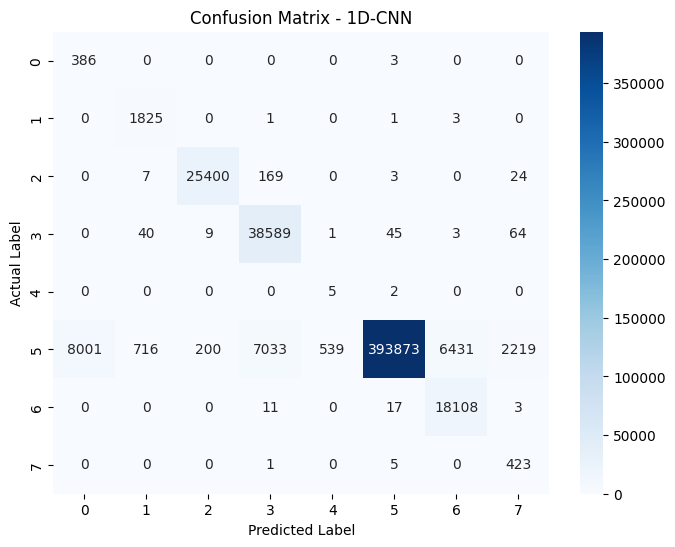

In [11]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_cnn = []
for train_idx, val_idx in kfold.split(X_train_dl, y_train):
    model = Sequential([
        Input(shape=input_shape),
        Conv1D(64, kernel_size=1, activation='relu'),
        MaxPooling1D(pool_size=1),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train_dl[train_idx], y_train_dl[train_idx], epochs=3, batch_size=256, verbose=0)
    _, acc = model.evaluate(X_train_dl[val_idx], y_train_dl[val_idx], verbose=0)
    cv_scores_cnn.append(acc) 
cnn_model = Sequential([
    Input(shape=input_shape),
    Conv1D(64, kernel_size=1, activation='relu'),
    MaxPooling1D(pool_size=1),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_cnn = cnn_model.fit(X_train_dl, y_train_dl, epochs=10, batch_size=128, validation_split=0.1, verbose=1)
y_pred_probs = cnn_model.predict(X_test_dl)
y_pred_cnn = np.argmax(y_pred_probs, axis=1)
train_acc_cnn = history_cnn.history['accuracy'][-1]
print_performance("1D-CNN", y_test, y_pred_cnn, train_acc_cnn, np.array(cv_scores_cnn))

# iv. Model 4 - Hybrid CNN-BiLSTM

Average CV Accuracy: 0.9923
Epoch 1/30
4219/4219 ━━━━━━━━━━━━━━━━━━━━ 46s 10ms/step - accuracy: 0.8898 - loss: 0.3296 - val_accuracy: 0.9874 - val_loss: 0.0556 - learning_rate: 0.0010
Epoch 2/30
4219/4219 ━━━━━━━━━━━━━━━━━━━━ 40s 9ms/step - accuracy: 0.9824 - loss: 0.0614 - val_accuracy: 0.9961 - val_loss: 0.0390 - learning_rate: 0.0010
Epoch 3/30
4219/4219 ━━━━━━━━━━━━━━━━━━━━ 40s 9ms/step - accuracy: 0.9880 - loss: 0.0442 - val_accuracy: 0.9975 - val_loss: 0.0343 - learning_rate: 0.0010
Epoch 4/30
4219/4219 ━━━━━━━━━━━━━━━━━━━━ 40s 10ms/step - accuracy: 0.9895 - loss: 0.0391 - val_accuracy: 0.9978 - val_loss: 0.0318 - learning_rate: 0.0010
Epoch 5/30
4219/4219 ━━━━━━━━━━━━━━━━━━━━ 40s 10ms/step - accuracy: 0.9903 - loss: 0.0362 - val_accuracy: 0.9990 - val_loss: 0.0281 - learning_rate: 0.0010
Epoch 6/30
4219/4219 ━━━━━━━━━━━━━━━━━━━━ 40s 9ms/step - accuracy: 0.9910 - loss: 0.0335 - val_accuracy: 0.9987 - val_loss: 0.0340 - learning_rate: 0.0010
Epoch 7/30
4219/4219 ━━━━━━━━━━━━━━━━━━

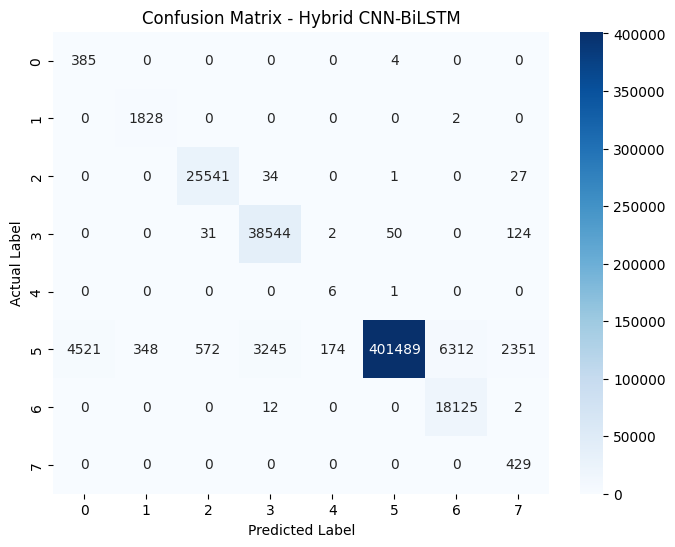

In [17]:
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed) 
set_seed(42) 
n_features = X_train.shape[1] 
X_train_dl_new = X_train.values.reshape(X_train.shape[0], n_features, 1)
X_test_dl_new = X_test.values.reshape(X_test.shape[0], n_features, 1)
input_shape_new = (n_features, 1)   
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_hybrid = []  
early_stop_cv = EarlyStopping(monitor='accuracy', patience=2, restore_best_weights=True)
for train_idx, val_idx in kfold.split(X_train_dl_new, y_train):
    inp = Input(shape=input_shape_new)  
    x = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(inp)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)  
    x = Dropout(0.3)(x) 
    x = Bidirectional(LSTM(128, return_sequences=False))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x) 
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    out = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=inp, outputs=out)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train_dl_new[train_idx], y_train_dl[train_idx], 
              epochs=8,  
              batch_size=256, 
              verbose=0,
              callbacks=[early_stop_cv]) 
    
    _, acc = model.evaluate(X_train_dl_new[val_idx], y_train_dl[val_idx], verbose=0)
    cv_scores_hybrid.append(acc)
mean_cv_hybrid = np.mean(cv_scores_hybrid)
print(f"Average CV Accuracy: {mean_cv_hybrid:.4f}") 
early_stop = EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.00001)
inp = Input(shape=input_shape_new)
x = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(inp)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.3)(x) 
x = Bidirectional(LSTM(128, return_sequences=False))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x) 
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
out = Dense(num_classes, activation='softmax')(x)
hybrid_model = Model(inputs=inp, outputs=out)
hybrid_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_h = hybrid_model.fit(
    X_train_dl_new, y_train_dl, 
    epochs=30, 
    batch_size=256, 
    validation_split=0.1, 
    callbacks=[early_stop, reduce_lr],
    verbose=1
)  
y_pred_probs_h = hybrid_model.predict(X_test_dl_new)
y_pred_hybrid = np.argmax(y_pred_probs_h, axis=1)
train_acc_h = history_h.history['accuracy'][-1]
print_performance("Hybrid CNN-BiLSTM", y_test, y_pred_hybrid, train_acc_h, np.array(cv_scores_hybrid))

# D. Final Comparison


Performance Table:


,Model,Accuracy,Precision,Recall,F1-Score
0,Decision Tree,91.324778,96.613386,91.324778,93.451501
1,KNN,85.554784,92.620152,85.554784,87.471327
2,1D-CNN,94.931966,97.534320,94.931966,95.968419
3,Hybrid CNN-BiLSTM,96.466796,98.133954,96.466796,97.123548


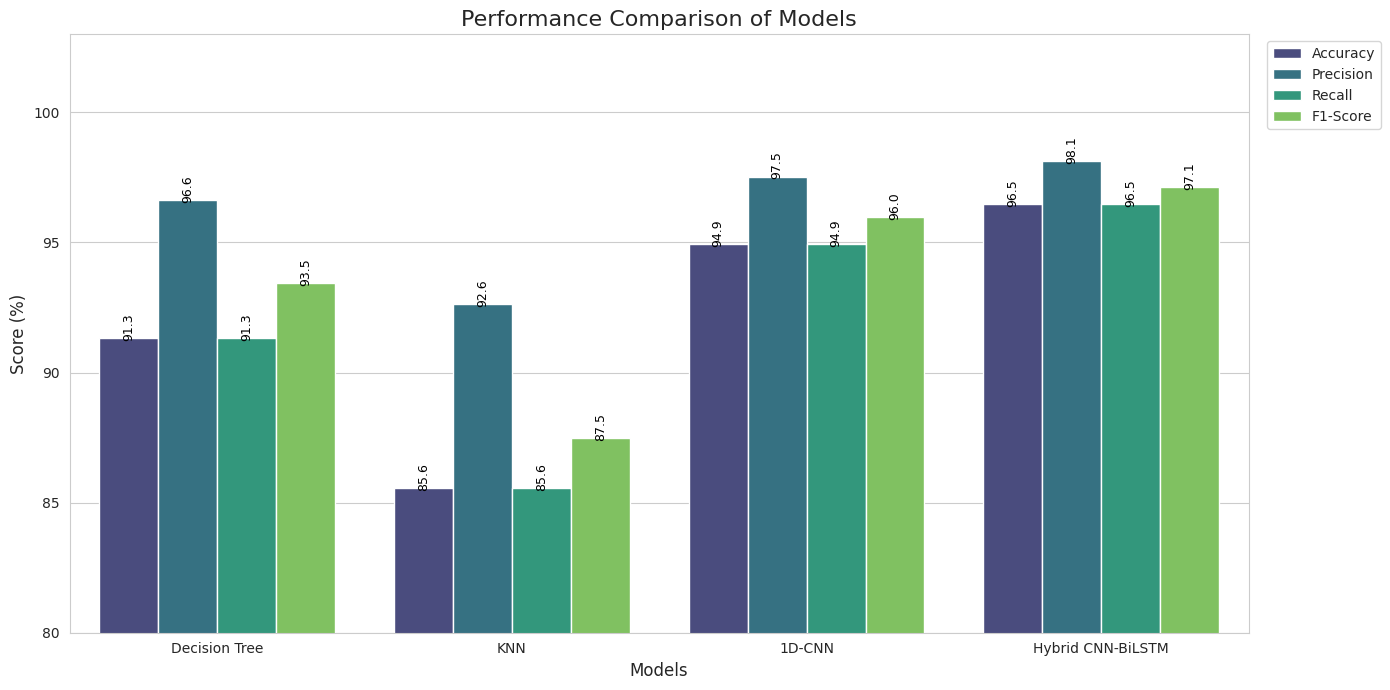

In [18]:
models_preds = {
    'Decision Tree': y_pred_dt,
    'KNN': y_pred_knn,
    '1D-CNN': y_pred_cnn,
    'Hybrid CNN-BiLSTM': y_pred_hybrid
} 
def get_metrics(y_true, y_pred, model_name):
    acc = accuracy_score(y_true, y_pred) * 100
    prec = precision_score(y_true, y_pred, average='weighted', zero_division=0) * 100
    rec = recall_score(y_true, y_pred, average='weighted', zero_division=0) * 100
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0) * 100
    return [model_name, acc, prec, rec, f1] 
data = []
metrics_cols = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score']
for name, preds in models_preds.items(): 
    if preds.ndim > 1: 
        preds = np.argmax(preds, axis=1)
    data.append(get_metrics(y_test, preds, name))
df_metrics = pd.DataFrame(data, columns=metrics_cols)
print("\nPerformance Table:")
display(df_metrics)
df_melted = df_metrics.melt(id_vars="Model", var_name="Metric", value_name="Score")
plt.figure(figsize=(14, 7))
sns.set_style("whitegrid")
ax = sns.barplot(x="Model", y="Score", hue="Metric", data=df_melted, palette="viridis")
plt.title("Performance Comparison of Models", fontsize=16)
plt.ylabel("Score (%)", fontsize=12)
plt.xlabel("Models", fontsize=12)
plt.ylim(80, 103)  
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
for p in ax.patches:
    if p.get_height() > 0: 
        ax.annotate(f'{p.get_height():.1f}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 8), 
                    textcoords = 'offset points',
                    fontsize=9, color='black', rotation=90)
plt.tight_layout()
plt.show()

ANOVA P-value: 0.000000

---Test Results ---
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper  reject
--------------------------------------------------
1D-CNN     DT   0.0095 0.0001 0.0057 0.0133   True
1D-CNN Hybrid    0.023    0.0 0.0192 0.0268   True
    DT Hybrid   0.0135    0.0 0.0097 0.0173   True
--------------------------------------------------


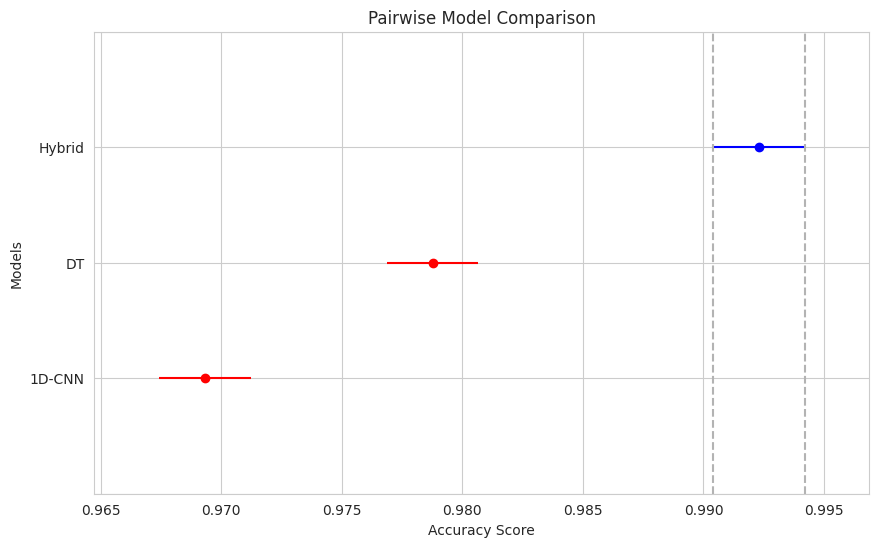

In [23]:
data = {
    'Score': list(cv_scores_dt) + list(cv_scores_cnn) + list(cv_scores_hybrid),
    'Model': ['DT']*5 + ['1D-CNN']*5 + ['Hybrid']*5
}
df = pd.DataFrame(data)
 
f_stat, p_val_anova = stats.f_oneway(cv_scores_dt, cv_scores_cnn, cv_scores_hybrid)
print(f"ANOVA P-value: {p_val_anova:.6f}")
 
if p_val_anova < 0.05:
    print("\n---Test Results ---")
    tukey = pairwise_tukeyhsd(endog=df['Score'], groups=df['Model'], alpha=0.05)
    print(tukey)
     
    tukey.plot_simultaneous(comparison_name='Hybrid')
    plt.title("Pairwise Model Comparison")
    plt.xlabel("Accuracy Score")
    plt.ylabel("Models")
    plt.show()

else:
    print("No statistically significant difference was found between the models.")

# E. Saving Models

In [24]:
hybrid_model.save('hybrid_model.keras')
cnn_model.save('cnn_model.keras') 
joblib.dump(dt_model, 'dt_model.pkl')
joblib.dump(knn_model, 'knn_model.pkl')
print("All 4 models saved successfully!")

All 4 models saved successfully!
